# ***Messages***

In [24]:
positive_message = "You are a possible covid suspect. Kindly take precautionary measures until you are verified by an expert."
negative_message = "You are tested as covid negative. Kindly take preventive measures and consult a doctor forfurther verification."
file_num = 1
common_path="/content/drive/MyDrive/Synthetic Data/SyntheticData  ("

## ***Mounting Drive***

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Required packages***

In [26]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ***CT Scan***

In [28]:
from tensorflow import keras
model_CT_Scan = keras.models.load_model('/content/drive/MyDrive/Model Saves/Resnet101 CT-Scan')  #***************************change variable name accordingly
import tensorflow as tf
import numpy as np

CT_scan_prediction = None

current_path_ct=common_path+str(file_num)+")/SyntheticData"+str(file_num)+"_ctscan.png"
# Open an image file
try:
  img = tf.keras.preprocessing.image.load_img(current_path_ct, target_size=(128, 128))
except:
  try:
    current_path_ct=common_path+str(file_num)+")/SyntheticData"+str(file_num)+"_ctscan.jpeg"
    img = tf.keras.preprocessing.image.load_img(current_path_ct, target_size=(128, 128))
  except:
    current_path_ct=common_path+str(file_num)+")/SyntheticData"+str(file_num)+"_ctscan.jpg"
    img = tf.keras.preprocessing.image.load_img(current_path_ct, target_size=(128, 128))
    
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Add an extra dimension to the image (since VGG16 expects a 4D input)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (subtracting the mean RGB value)
img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)

# Use the model to classify the image
predictions = model_CT_Scan.predict(img_array)                                       #********************change model name here as well

if float(format(predictions[0][0]+predictions[0][1], '.2f')) > float(format(predictions[0][2], '.2f')):
  CT_scan_prediction=1  #assuming covid = 1           ************************** use list according to the name of the dataset.. see in cell 1
else:
  CT_scan_prediction=0 #assuming non-covid = 0            ************************** use list according to the name of the dataset.. see in cell 1  


1/1 [==============================] - 2s 2s/step


# ***X-ray***

In [29]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import cv2

Xray_model = keras.models.load_model('/content/drive/MyDrive/Model Saves/VGG16 Xray')
xray_prediction = None

#current image path

current_path=common_path+str(file_num)+")/SyntheticData"+str(file_num)+"_xray.jpeg"
img=None
try: 
  img = tf.keras.preprocessing.image.load_img(current_path, target_size=(150, 150))
  
except:
  try:
    current_path=common_path+str(file_num)+")/SyntheticData"+str(file_num)+"_xray.png"
    img = tf.keras.preprocessing.image.load_img(current_path, target_size=(150, 150))
  except:
    current_path=common_path+str(file_num)+")/SyntheticData"+str(file_num)+"_xray.jpg"
    img = tf.keras.preprocessing.image.load_img(current_path, target_size=(150, 150))

# Open an image file
# Convert the image to a numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)
# Add an extra dimension to the image (since VGG16 expects a 4D input)
img_array = np.expand_dims(img_array, axis=0)
# Preprocess the image (subtracting the mean RGB value)
img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)
# Use the model to classify the image
predictions = Xray_model.predict(img_array)

if float(format(predictions[0][0], '.2f')) > float(format(predictions[0][1], '.2f')):
  xray_prediction=1
else:
  xray_prediction=0

1/1 [==============================] - 0s 160ms/step


# ***Heavy cough***

In [30]:
from tensorflow import keras
from pydub import AudioSegment
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    samples = np.append(samples, np.zeros(frameSize))
    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]
    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    return ims
def plot_save_return_address(path_to_get, sample_num):
  ims = plotstft(path_to_get)
  plt.figure(figsize=(15, 7.5))
  plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap="jet", interpolation="none")
  plt.axis("off")

  plotpath ='/content/'+"SyntheticData"+str(sample_num)+"_caugh_spectrogram.png"
  plt.savefig(plotpath, bbox_inches="tight")
  return plotpath

In [31]:
Heavy_Cough_model = keras.models.load_model('/content/drive/MyDrive/Model Saves/VGG16 Heavy Cough')

<ipython-input-30-c071f280f714>:48: RuntimeWarning: divide by zero encountered in log10
  ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel


1/1 [==============================] - 0s 119ms/step


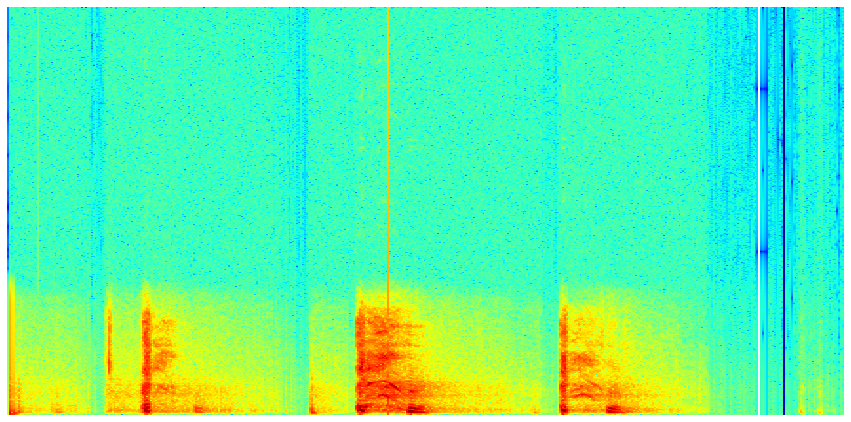

In [32]:
cough_prediction = None

# Open an image file

wav_file_path_cough = common_path+str(file_num)+")/SyntheticData"+str(file_num)+"_cough.wav"

# reading the .mp3 audio file exporting to .wav format
AudioSegment.from_mp3(wav_file_path_cough).export(wav_file_path_cough, format="wav")

spectrogram_file_path= plot_save_return_address(wav_file_path_cough, file_num)

img = tf.keras.preprocessing.image.load_img(spectrogram_file_path, target_size=(224,224))

# Open an image file
# Convert the image to a numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)
# Add an extra dimension to the image (since VGG16 expects a 4D input)
img_array = np.expand_dims(img_array, axis=0)
# Preprocess the image (subtracting the mean RGB value)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
# Use the model to classify the image
predictions = Heavy_Cough_model.predict(img_array)

if float(format(predictions[0][0]+predictions[0][2], '.2f')) > float(format(predictions[0][1], '.2f')):
  cough_prediction=1
else:
  cough_prediction=0


# ***Deep Breathing***

In [33]:
from tensorflow import keras
from pydub import AudioSegment
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    samples = np.append(samples, np.zeros(frameSize))
    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]
    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    return ims
def plot_save_return_address(path_to_get, sample_num):
  ims = plotstft(path_to_get)
  plt.figure(figsize=(15, 7.5))
  plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap="jet", interpolation="none")
  plt.axis("off")

  plotpath ='/content/'+"SyntheticData"+str(sample_num)+"_breath_spectrogram.png"
  plt.savefig(plotpath, bbox_inches="tight")
  return plotpath

In [34]:
Deep_Breath_model = keras.models.load_model('/content/drive/MyDrive/Model Saves/Resnet50 Deep Breath')

<ipython-input-33-76fecde2d846>:48: RuntimeWarning: divide by zero encountered in log10
  ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel


1/1 [==============================] - 1s 871ms/step


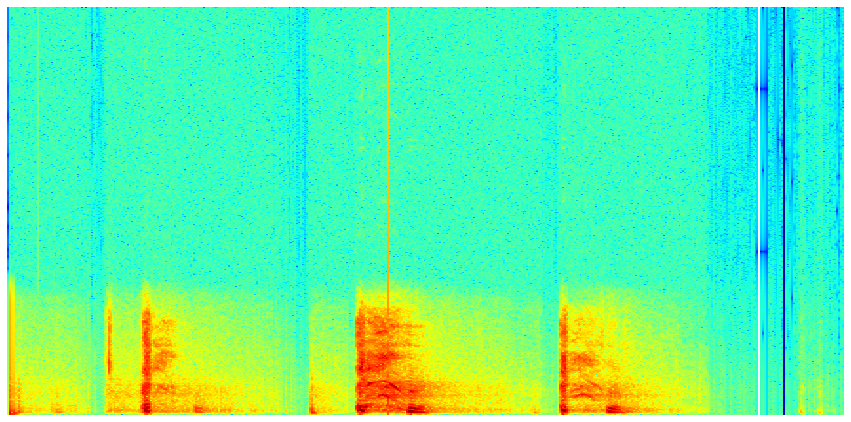

In [35]:
deep_breath_prediction = []
  
# # output file location

wav_file_path_breath = common_path+str(file_num)+")/SyntheticData"+str(file_num)+"_breath.wav"

# reading the .mp3 audio file exporting to .wav format
AudioSegment.from_mp3(wav_file_path_cough).export(wav_file_path_breath, format="wav")

spectrogram_file_path= plot_save_return_address(wav_file_path_breath, file_num)

img = tf.keras.preprocessing.image.load_img(spectrogram_file_path, target_size=(224,224))

# Open an image file
# Convert the image to a numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)
# Add an extra dimension to the image (since VGG16 expects a 4D input)
img_array = np.expand_dims(img_array, axis=0)
# Preprocess the image (subtracting the mean RGB value)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
# Use the model to classify the image
predictions =Deep_Breath_model.predict(img_array)

if float(format(predictions[0][1], '.2f')) < 0.96:
  deep_breath_prediction=1
else:
  deep_breath_prediction=0


# ***Final Result***

# ***4 parameters- CTScan, X-ray, Heavy Cough Sound, Breathing sound***

In [50]:
CT_scan_weight_4para = 0.39236546838661474 
X_ray_weight_4para = 0.292364637070311 
cough_weight_4para = 0.23368775878226913 
breath_weight_4para = 0.08158213576080497
threshold_4para = CT_scan_weight_4para
severity = "N/A"
perform_test = "N/A"
self_isolation = "N/A"
doctor_consultation = "N/A"

final_result_4para = CT_scan_weight_4para * CT_scan_prediction + X_ray_weight_4para * xray_prediction + cough_weight_4para * cough_prediction + breath_weight_4para *  deep_breath_prediction

print("Synthetic data ", file_num,":\n", sep="")

if final_result_4para >= threshold_4para:
  print("POSITIVE\n")
  print(positive_message)
  perform_test = "PCR"
  self_isolation = "Yes"
  doctor_consultation = "Yes" 

  if CT_scan_prediction == 1:
    if xray_prediction == 1:
      severity = "Definite"
    else:
      severity = "Very Significant"
  else:
    if xray_prediction == 1: 
      
      if cough_prediction == 0 and deep_breath_prediction == 0:
        severity = "Significant"
      else:
        severity = "Very Significant"
else:
  print("NEGATIVE\n")
  print(negative_message)
  perform_test = "Antigen"
  doctor_consultation = "Yes (Followup Needed)" 
  if cough_prediction == 1 and deep_breath_prediction == 1:
    severity="Very Suspicious"
  elif (cough_prediction == 1 and deep_breath_prediction == 0) or (cough_prediction == 0 and deep_breath_prediction == 1):
    severity="Suspicious"
  else:
    severity="Definite"
    doctor_consultation = "N/A"
    perform_test = "N/A"

print("\nSeverity :", severity)
print("Recommended Test:", perform_test)
print("Self Isolation:", self_isolation)
print("Doctor Consultation :", doctor_consultation)

Synthetic data 1:

POSITIVE

You are a possible covid suspect. Kindly take precautionary measures until you are verified by an expert.

Severity : Definite
Recommended Test: PCR
Self Isolation: Yes
Doctor Consultation : Yes


# ***3 parameters- CTScan, Heavy Cough Sound, Breathing sound***

In [49]:
CT_scan_weight_3para_1 = 0.5984521366978428 
cough_weight_3para_1 = 0.25670876803825354 
breath_weight_3para_1 = 0.1448390952639037
threshold_3para_1 = CT_scan_weight_3para_1
severity = "N/A"
perform_test = "N/A"
self_isolation = "N/A"
doctor_consultation = "N/A"

final_result_3para_1 = CT_scan_weight_3para_1 * CT_scan_prediction + cough_weight_3para_1 * cough_prediction + breath_weight_3para_1 *  deep_breath_prediction

print("Synthetic data ", file_num,":\n", sep="")

if final_result_3para_1 >= threshold_3para_1:
  print("POSITIVE\n")
  print(positive_message)
  perform_test = "PCR"
  self_isolation = "Yes"
  doctor_consulatation = "Yes"
  if CT_scan_prediction == 1 and (cough_prediction == 0 and deep_breath_prediction == 0):
    severity = "Significant"
  else:
    severity = "Very Significant"
else:
  print("NEGATIVE\n")
  print(negative_message)
  perform_test = "Antigen"
  if CT_scan_prediction == 0 and cough_prediction == 0 and deep_breath_prediction == 0:
    severity = "Definite"
  elif cough_prediction == 1 and deep_breath_prediction == 1:
    severity = "Very Suspicious"
  else:
    severity = "Suspicious"

print("\nSeverity :", severity)
print("Recommended Test:", perform_test)
print("Self Isolation:", self_isolation)
print("Doctor Consultation :", doctor_consultation)

Synthetic data 1:

POSITIVE

You are a possible covid suspect. Kindly take precautionary measures until you are verified by an expert.

Severity : Very Significant
Recommended Test: PCR
Self Isolation: Yes
Doctor Consultation : N/A


# ***3 parameters- X-ray, Heavy Cough Sound, Breathing sound***

In [47]:
X_ray_weight_3para_2 = 0.5972434353588354 
cough_weight_3para_2 = 0.2567723289174224 
breath_weight_3para_2 = 0.1459842357237421
threshold_3para_2 = X_ray_weight_3para_2

final_result_3para_2 = X_ray_weight_3para_2 * xray_prediction + cough_weight_3para_2 * cough_prediction + breath_weight_3para_2 *  deep_breath_prediction

print("Synthetic data ", file_num,":\n", sep="")

if final_result_3para_1 >= threshold_3para_1:
  print("POSITIVE\n")
  print(positive_message)
  perform_test = "PCR"
  self_isolation = "Yes"
  doctor_consulatation = "Yes"
  if xray_prediction == 1 and (cough_prediction == 0 and deep_breath_prediction == 0):
    severity = "Significant"
  else:
    severity = "Very Significant"
else:
  peint("NEGATIVE\n")
  print(negative_message)
  perform_test = "Antigen"
  if xray_prediction == 0 and cough_prediction == 0 and deep_breath_prediction == 0:
    severity = "Definite"
  elif cough_prediction == 1 and deep_breath_prediction == 1:
    severity = "Very Suspicious"
  else:
    severity = "Suspicious"
  
print("\nSeverity :", severity)
print("Recommended Test:", perform_test)
print("Self Isolation:", self_isolation)
print("Doctor Consultation :", doctor_consultation)

Synthetic data 1:

POSITIVE

You are a possible covid suspect. Kindly take precautionary measures until you are verified by an expert.

Severity : Very Significant
Recommended Test: PCR
Self Isolation: Yes
Doctor Consultation : N/A
